In [ ]:
# !pip install geopandas
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import collections
# import geopandas as gpd
from shapely.geometry import Point, Polygon 
import descartes
import matplotlib.pyplot as plt

%matplotlib inline

## Data Description, Cleaning and Processing 

### 1. Data Source and Description

listings.csv.gz - Detailed Listings data for New York City
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/data/listings.csv.gz

calendar.csv.gz	- Detailed Calendar Data for listings in New York City
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/data/calendar.csv.gz

reviews.csv.gz - Detailed Review Data for listings in New York City
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/data/reviews.csv.gz

listings.csv - Summary information and metrics for listings in New York City (good for visualisations).
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/visualisations/listings.csv

reviews.csv - Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/visualisations/reviews.csv

neighbourhoods.csv - Neighbourhood list for geo filter. Sourced from city or open source GIS files.
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/visualisations/neighbourhoods.csv

neighbourhoods.geojson - GeoJSON file of neighbourhoods of the city.
http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/visualisations/neighbourhoods.geojson


In [ ]:
# LOAD DATA FROM URL 
# basic listing info from listings.csv 
url_listing_summary = 'http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/visualisations/listings.csv'
listing_summary = pd.read_csv(url_listing_summary)

# detail listing info from listings.csv.gz
url_listing_detail = 'http://data.insideairbnb.com/united-states/ny/new-york-city/2020-03-13/data/listings.csv.gz'
listing_detail = pd.read_csv(url_listing_detail, compression='gzip',error_bad_lines=False,low_memory=False)

# We only need above for now


In [ ]:
print("Summary information and metrics for listings in New York City: \n Initial dataset shape = ", listing_detail.shape)
listing_detail.describe()

Summary information and metrics for listings in New York City: 
 Initial dataset shape =  (50796, 106)


,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,5.079600e+04,5.079600e+04,0.0,0.0,0.0,5.079600e+04,50791.000000,50791.000000,50796.000000,50796.000000,50796.000000,50742.000000,50719.000000,50314.000000,389.000000,50796.000000,50796.000000,5.079600e+04,50796.000000,50796.000000,5.079600e+04,5.079600e+04,50796.000000,5.079600e+04,50796.000000,50796.000000,50796.000000,50796.000000,50796.000000,50796.000000,39365.000000,39330.000000,39344.000000,39317.000000,39333.000000,39314.000000,39314.000000,50796.000000,50796.000000,50796.000000,50796.000000,40343.000000
mean,2.262308e+07,2.020031e+13,NaN,NaN,NaN,8.499340e+07,23.644780,23.644780,40.729151,-73.950834,2.862095,1.146240,1.181234,1.545474,682.920308,1.517147,7.396547,8.593957e+04,7.237401,13.089830,1.269759e+06,1.312040e+06,12.272147,1.278177e+06,10.976770,22.266163,34.207595,119.513702,25.080243,9.159737,93.903137,9.613552,9.284211,9.734848,9.740066,9.599812,9.386351,8.097764,6.283802,1.586129,0.128632,1.282087
std,1.317395e+07,1.122277e+01,NaN,NaN,NaN,9.757076e+07,165.173607,165.173607,0.054842,0.047763,1.890896,0.427081,0.759447,1.135840,506.393053,1.163358,21.337208,1.347548e+07,23.839106,68.819887,5.217383e+07,5.303573e+07,60.052922,5.220810e+07,12.131939,23.903733,35.961176,135.250201,48.874961,16.542545,8.849797,0.859817,1.084723,0.751754,0.771954,0.750225,0.939184,35.145843,34.504970,7.692647,1.263475,1.625176
min,2.060000e+03,2.020031e+13,NaN,NaN,NaN,2.259000e+03,0.000000,0.000000,40.499790,-74.240840,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.091687e+07,2.020031e+13,NaN,NaN,NaN,9.531972e+06,1.000000,1.000000,40.689718,-73.983272,2.000000,1.000000,1.000000,1.000000,300.000000,1.000000,1.000000,2.900000e+01,1.000000,2.000000,3.000000e+01,3.000000e+01,1.300000,3.000000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.180000
50%,2.222731e+07,2.020031e+13,NaN,NaN,NaN,3.862553e+07,1.000000,1.000000,40.723510,-73.955150,2.000000,1.000000,1.000000,1.000000,700.000000,1.000000,2.000000,7.300000e+02,2.000000,3.000000,1.125000e+03,1.125000e+03,2.900000,1.125000e+03,4.000000,12.000000,21.000000,66.000000,5.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.640000
75%,3.490751e+07,2.020031e+13,NaN,NaN,NaN,1.385156e+08,2.000000,2.000000,40.763040,-73.933870,4.000000,1.000000,1.000000,2.000000,904.000000,2.000000,5.000000,1.125000e+03,5.000000,5.000000,1.125000e+03,1.125000e+03,5.000000,1.125000e+03,24.000000,46.000000,72.000000,237.000000,25.000000,11.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,1.000000,0.000000,1.900000
max,4.289272e+07,2.020031e+13,NaN,NaN,NaN,3.414399e+08,2345.000000,2345.000000,40.911690,-73.711560,22.000000,15.500000,21.000000,40.000000,3700.000000,16.000000,1250.000000,2.147484e+09,1250.000000,4513.000000,2.1

In [ ]:
listing_detail.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2060,https://www.airbnb.com/rooms/2060,20200313233810,2020-03-14,Modern NYC,NaN,"Lovely, spacious, sunny 1 BR apartment in 6th ...","Lovely, spacious, sunny 1 BR apartment in 6th ...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/3755/3f9d3...,NaN,2259,https://www.airbnb.com/users/show/2259,Jenny,2008-08-18,US,NaN,a few days or more,22%,50%,f,https://a0.muscache.com/im/users/2259/profile_...,https://a0.muscache.com/im/users/2259/profile_...,Washington Heights,0.0,0.0,['reviews'],t,f,"New York, NY, United States",Manhattan,Washington Heights,...,$0.00,1,730,1,1,730,730,1.0,730.0,4 weeks ago,t,30,60,90,365,2020-03-14,1,0,2008-09-22,2008-09-22,80.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,0,1,0,0.01
1,2595,https://www.airbnb.com/rooms/2595,20200313233810,2020-03-14,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,87%,38%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, NY, United States",Midtown,Midtown,...,$0.00,7,1125,7,7,1125,1125,7.0,1125.0,4 months ago,t,4,34,64,339,2020-03-14,48,5,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.38
2,3831,https://www.airbnb.com/rooms/3831,20200313233810,2020-03-14,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,"You will have the private, exclusive use of an...","We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New Y

In [ ]:
print("List of columns in listing_detail (raw):\n")
raw_features =list(listing_detail.columns)
raw_features

In [ ]:
raw_features

### 2. Data Processing
### 2.1 Convert Numeric Variables to Type of Float and Handle NaN -OK


In [ ]:

# convert price, extra_people, security_deposit,cleaning_fee columns to type float or int 
listing_detail['price'] = listing_detail['price'].apply(lambda x: float(x[1:].replace(',', '')))
listing_detail['extra_people'] = listing_detail['extra_people'].apply(lambda x: float(x[1:].replace(',', '')))

# for security_deposit and cleaning_fee, first replace NaN with 0
listing_detail['security_deposit'] = listing_detail['security_deposit'].fillna(0.0)
listing_detail['security_deposit'] = listing_detail['security_deposit'].apply(lambda x: float(x[1:].replace(',', '')) if x != 0.0 else x)

listing_detail['cleaning_fee'] = listing_detail['cleaning_fee'].fillna(0.0)
listing_detail['cleaning_fee'] = listing_detail['cleaning_fee'].apply(lambda x: float(x[1:].replace(',', '')) if x != 0.0 else x)

# convert host_response_rate, host_acceptance_rate from % to numeric float
listing_detail['host_response_rate'] = listing_detail['host_response_rate'].fillna(0.0)
listing_detail['host_response_rate'] = listing_detail['host_response_rate'].apply(lambda x: float(x[:-1]) if x != 0.0 else x)

listing_detail['host_acceptance_rate'] = listing_detail['host_acceptance_rate'].fillna(0.0)
listing_detail['host_acceptance_rate'] = listing_detail['host_acceptance_rate'].apply(lambda x: float(x[:-1]) if x != 0.0 else x)

# Handle NaN by fillna with 0.0 for 'bathrooms', 'bedrooms', 'beds'
listing_detail['bathrooms'] = listing_detail['bathrooms'].fillna(0.0)
listing_detail['bedrooms'] = listing_detail['bedrooms'].fillna(0.0)
listing_detail['beds'] = listing_detail['beds'].fillna(0.0)

### 2.2 Formulate Target Variable - OK
- Our goal is to predict the revenue for Airbnb listing. Since in our dataset we do not have a value for revenue. Suggested by Inside Airbnb's "San Francisco Model", we define a new variable "yield" as a estimate of the revenue:


> Yield = avg_length_per_stay(nights) * avg_price * reviews_per_month / reviews_ratio


we use estimated review rate of 50% 

Yield = 6.4 nights * price * reviews_per_month / 50% 

- Define occupancy as

> Occupancy = avg_length_per_stay(nights) * reviews_per_month / reviews_ratio

- Define relative_occupancy as occupacy level comparing to neighbourhood median 
 

> relative_occupancy(Listing) = 1 if above median, else 0


In [ ]:
avg_length_per_stay = 6.4
reviews_ratio = 0.5 

# create column "yield"
listing_detail['yield'] = avg_length_per_stay * listing_detail['price'] * listing_detail['reviews_per_month']/ reviews_ratio

# create column "occupancy"
listing_detail['occupancy'] = avg_length_per_stay * listing_detail['reviews_per_month']/ reviews_ratio
# listing_detail.head(3)

In [ ]:
# occupancy medians by neighbourhood_group_cleansed
occupancy_med_by_neighbourhood = listing_detail[['neighbourhood_group_cleansed', 'occupancy']].groupby('neighbourhood_group_cleansed').median()
map_medbyneigh = occupancy_med_by_neighbourhood.to_dict()['occupancy'] # create dictionary 

# define binary variable relative_ccupancy as occupacy level comparing to neighbourhood median, 
# 1 if above median, else 0
listing_detail['relative_ocupancy'] = listing_detail.apply(lambda x: 1 if x['occupancy'] >= map_medbyneigh[x['neighbourhood_group_cleansed']] else 0, axis=1)
# listing_detail.head(5)

### 2.3 Drop the unnecessary -OK


Some are unnecessary variables. Some variables including various review scores could be useful in predicting yield; however, such informations are not available for new listings. So we decide to model without those variables.
Variables including square_feet has too many NaNs are dropped.



> "id", "listing_url", "scrape_id", "last_scraped", "name", "city", "state","zipcode","market","smart_location","country_code","country","calendar_updated","has_availability","availability_30","availability_60", "availability_90","availability_365","calendar_last_scraped", "first_review","last_review","host_id","host_url","host_name","host_since",	"host_location","host_response_time", "street", "neighbourhood", "license", "jurisdiction_names", "host_thumbnail_url", "experiences_offered", "latitude","longitude","weekly_price", "monthly_price", "reviews_per_month","number_of_reviews","number_of_reviews_ltm","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value", "square_feet"



In [ ]:
removed_cols = ["id", "listing_url", "scrape_id", "last_scraped", "name", "city", "state","zipcode","market","smart_location","country_code","country","calendar_updated","has_availability","availability_30","availability_60", "availability_90","availability_365","calendar_last_scraped", "first_review","last_review","host_id","host_url","host_name","host_since",	"host_location","host_response_time", "street", "neighbourhood", "license", "jurisdiction_names", "host_thumbnail_url", "experiences_offered", "latitude","longitude","weekly_price", "monthly_price", "reviews_per_month","number_of_reviews","number_of_reviews_ltm","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","square_feet","notes","house_rules","thumbnail_url","medium_url","xl_picture_url","host_about","host_picture_url","host_neighbourhood","host_verifications","host_has_profile_pic","minimum_nights","maximum_nights","minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights","minimum_nights_avg_ntm", "maximum_nights_avg_ntm","requires_license","is_business_travel_ready","require_guest_profile_picture","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms","space"] # "neighbourhood_group_cleansed"
cleaned_listing_detail = listing_detail.drop(removed_cols, axis=1)
print("shape after dropping columns = ", cleaned_listing_detail.shape)
# cleaned_listing_detail.head(3)

shape after dropping columns =  (50796, 35)


**Additional columns being deducted:**
"notes",
"house_rules",
"thumbnail_url",
"medium_url",
"xl_picture_url",
"host_about",
"host_picture_url",
"host_neighbourhood",
"host_verifications",
"host_has_profile_pic",
"minimum_nights",
"maximum_nights",
"minimum_minimum_nights",
"maximum_minimum_nights",
"minimum_maximum_nights",
"maximum_maximum_nights",
"minimum_nights_avg_ntm", 
"maximum_nights_avg_ntm",
"requires_license",
"is_business_travel_ready",
"require_guest_profile_picture",
"calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms",
"space",
"neighbourbood_group_cleansed"

### 2.4 Process Binary & Categorical Variables -OK
#### Transform Some Descriptive String Variables to Binary Varaibles - OK 
1 if has description, 0 if NaN
1. summary: we keep summary for later text analysis
2. space: 1 if has space description, 0 if NaN
3. description: 1 if has description, 0 if NaN
4. neighborhood_overview: : 1 if has neighborhood_overview description, 0 if NaN
5. notes: 1 if has description, 0 if NaN
6. transit: 1 if has transit description, 0 if NaN
7. access: 1 if has access description, 0 if NaN
8. house_rules: 1 if has house_rules description, 0 if NaN
9. thumbnail_url: 1 if has thumbnail_url, 0 if NaN
10. medium_url: 1 if has medium_url, 0 if NaN
11. interaction: 1 if has interaction description, 0 if NaN
12. picture_url	: 1 if has picture_url, 0 if NaN
13. xl_picture_url: 1 if has xl_picture_url, 0 if NaN
14. host_picture_url: 1 if has host_picture_url, 0 if NaN
15. host_about



In [ ]:
descriptive_vars = ['description', 'neighborhood_overview', 'transit', 'access','interaction', 'picture_url'] # 'summary' 
# transform descriptive_vars to binary variables with values 0 and 1 
cleaned_listing_detail[descriptive_vars] = cleaned_listing_detail[descriptive_vars].notnull().astype(int)
cleaned_listing_detail.head(3)

,summary,description,neighborhood_overview,transit,access,interaction,picture_url,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,cancellation_policy,require_guest_phone_verification,yield,occupancy,relative_ocupancy
0,NaN,1,0,0,0,0,1,22.0,50.0,f,0.0,0.0,f,Washington Heights,Manhattan,t,Other,Private room,2,0.0,1.0,2.0,Real Bed,"{Internet,Wifi}",100.0,0.0,0.0,1,0.0,f,flexible,f,12.800,0.128,0
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,1,87.0,38.0,f,6.0,6.0,t,Midtown,Manhattan,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,95.0,1,0.0,f,strict_14_with_grace_period,t,1094.400,4.864,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,1,83.0,96.0,f,1.0,1.0,t,Clinton Hill,Brooklyn,t,Guest suite,Entire home/apt,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",89.0,500.0,0.0,1,0.0,f,moderate,f,5365.632,60.288,1


#### Transform Some Binary Vars With Values "t" or "f" to 1 or 0: - OK
1. host_is_superhost
2. host_has_profile_pic	
3. host_identity_verified 
4. requires_license	
5. instant_bookable	
6. is_business_travel_ready
7. is_location_exact
8. require_guest_profile_picture
9. require_guest_phone_verification


In [ ]:
tf_vars = ['host_is_superhost', 'host_identity_verified', 'instant_bookable', "is_location_exact", "require_guest_phone_verification"]
tf = {"t": 1, "f":0}
for var in tf_vars:
  cleaned_listing_detail[var] = cleaned_listing_detail[var].map(tf).fillna(cleaned_listing_detail[var])
  
# From the updated descprtion, we want remove the columns that are all zeros or ones 
# picture_url 
removed_cols = ["picture_url"]
cleaned_listing_detail = cleaned_listing_detail.drop(removed_cols, axis=1)

In [ ]:
cleaned_listing_detail.head(3)

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,cancellation_policy,require_guest_phone_verification,yield,occupancy,relative_ocupancy
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Washington Heights,Manhattan,1,Other,Private room,2,0.0,1.0,2.0,Real Bed,"{Internet,Wifi}",100.0,0.0,0.0,1,0.0,0,flexible,0,12.800,0.128,0
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Midtown,Manhattan,0,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,95.0,1,0.0,0,strict_14_with_grace_period,1,1094.400,4.864,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Clinton Hill,Brooklyn,1,Guest suite,Entire home/apt,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",89.0,500.0,0.0,1,0.0,0,moderate,0,5365.632,60.288,1



#### Deal With Categorical Variables(Create dummy variables)


1. property_type		
2. room_type
3. bed_type
4. cancellation_policy
5. neighbourhood_cleansed: 223 groups, keep 10 and set "others" 

In [ ]:
df_dummified = cleaned_listing_detail.copy()

 **Property_type**

In [ ]:
property_value_counts = df_dummified.property_type.value_counts()
property_value_counts.head(10)
property_rare = property_value_counts[property_value_counts < 250].index
replace_map1 = {name: "OTHER" for name in property_rare}
df_dummified.property_type = df_dummified.property_type.replace(replace_map1)

In [ ]:
dummies = pd.get_dummies(df_dummified.property_type, prefix="Property_Type")
dummies.shape

(50796, 10)

In [ ]:
df_dummified.drop(["property_type"], axis=1, inplace=True)
df_dummified = pd.concat((cleaned_listing_detail, dummies), axis=1)
df_dummified.head(3)

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,cancellation_policy,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Washington Heights,Manhattan,1,Other,Private room,2,0.0,1.0,2.0,Real Bed,"{Internet,Wifi}",100.0,0.0,0.0,1,0.0,0,flexible,0,12.800,0.128,0,0,0,0,0,0,0,0,1,0,0
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Midtown,Manhattan,0,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,95.0,1,0.0,0,strict_14_with_grace_period,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Clinton Hill,Brooklyn,1,Guest suite,Entire home/apt,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",89.0,500.0,0.0,1,0.0,0,moderate,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0


**Room_type**

In [ ]:
room_value_counts = df_dummified.room_type.value_counts()
dummies = pd.get_dummies(df_dummified.room_type, prefix="Room_Type")
dummies.shape

(50796, 4)

In [ ]:
df_dummified.drop(["room_type"], axis=1, inplace=True)
df_dummified = pd.concat((df_dummified, dummies), axis=1)
df_dummified.head(3)

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,cancellation_policy,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse,Room_Type_Entire home/apt,Room_Type_Hotel room,Room_Type_Private room,Room_Type_Shared room
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Washington Heights,Manhattan,1,Other,2,0.0,1.0,2.0,Real Bed,"{Internet,Wifi}",100.0,0.0,0.0,1,0.0,0,flexible,0,12.800,0.128,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Midtown,Manhattan,0,Apartment,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,95.0,1,0.0,0,strict_14_with_grace_period,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Clinton Hill,Brooklyn,1,Guest suite,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",89.0,500.0,0.0,1,0.0,0,moderate,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0


**Bed_type**

In [ ]:
bed_value_counts = df_dummified.bed_type.value_counts()
dummies = pd.get_dummies(df_dummified.bed_type, prefix="Bed_Type")
dummies.shape

(50796, 5)

In [ ]:
df_dummified.drop(["bed_type"], axis=1, inplace=True)
df_dummified = pd.concat((df_dummified, dummies), axis=1)
df_dummified.head(3)

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,cancellation_policy,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse,Room_Type_Entire home/apt,Room_Type_Hotel room,Room_Type_Private room,Room_Type_Shared room,Bed_Type_Airbed,Bed_Type_Couch,Bed_Type_Futon,Bed_Type_Pull-out Sofa,Bed_Type_Real Bed
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Washington Heights,Manhattan,1,Other,2,0.0,1.0,2.0,"{Internet,Wifi}",100.0,0.0,0.0,1,0.0,0,flexible,0,12.800,0.128,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Midtown,Manhattan,0,Apartment,2,1.0,0.0,1.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,95.0,1,0.0,0,strict_14_with_grace_period,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Clinton Hill,Brooklyn,1,Guest suite,3,1.0,1.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",89.0,500.0,0.0,1,0.0,0,moderate,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


**Cancellation_Policy**

In [ ]:
cancel_value_counts = df_dummified.cancellation_policy.value_counts()
dummies = pd.get_dummies(df_dummified.cancellation_policy, prefix="cancellation_policy")
dummies.shape

(50796, 6)

In [ ]:
df_dummified.drop(["cancellation_policy"], axis=1, inplace=True)
df_dummified = pd.concat((df_dummified, dummies), axis=1)
df_dummified.head(3)

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse,Room_Type_Entire home/apt,Room_Type_Hotel room,Room_Type_Private room,Room_Type_Shared room,Bed_Type_Airbed,Bed_Type_Couch,Bed_Type_Futon,Bed_Type_Pull-out Sofa,Bed_Type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Washington Heights,Manhattan,1,Other,2,0.0,1.0,2.0,"{Internet,Wifi}",100.0,0.0,0.0,1,0.0,0,0,12.800,0.128,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Midtown,Manhattan,0,Apartment,2,1.0,0.0,1.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,95.0,1,0.0,0,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Clinton Hill,Brooklyn,1,Guest suite,3,1.0,1.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",89.0,500.0,0.0,1,0.0,0,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


**neighbourhood_cleansed**

In [ ]:
df_dummified['neighbourhood_cleansed'].value_counts().head(10)

Williamsburg          3844
Bedford-Stuyvesant    3831
Harlem                2753
Bushwick              2498
Hell's Kitchen        2143
Upper West Side       1935
East Village          1874
Upper East Side       1796
Crown Heights         1670
Midtown               1669
Name: neighbourhood_cleansed, dtype: int64

In [ ]:
neighbourhood_cleansed_counts = df_dummified.neighbourhood_cleansed.value_counts()
neighbourhood_cleansed_counts.head(10)
neighbourhood_cleansed_rare = neighbourhood_cleansed_counts[neighbourhood_cleansed_counts < 1669].index
replace_map2 = {name: "OTHER" for name in neighbourhood_cleansed_rare}
df_dummified.neighbourhood_cleansed = df_dummified.neighbourhood_cleansed.replace(replace_map2)

In [ ]:
dummies = pd.get_dummies(df_dummified.neighbourhood_cleansed, prefix="neighbourhood_cleansed")
dummies.shape

(50796, 11)

In [ ]:
df_dummified.drop(["neighbourhood_cleansed"], axis=1, inplace=True)
df_dummified = pd.concat((df_dummified, dummies), axis=1)
df_dummified.head(3)

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse,Room_Type_Entire home/apt,Room_Type_Hotel room,Room_Type_Private room,Room_Type_Shared room,Bed_Type_Airbed,Bed_Type_Couch,Bed_Type_Futon,Bed_Type_Pull-out Sofa,Bed_Type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,neighbourhood_cleansed_Bedford-Stuyvesant,neighbourhood_cleansed_Bushwick,neighbourhood_cleansed_Crown Heights,neighbourhood_cleansed_East Village,neighbourhood_cleansed_Harlem,neighbourhood_cleansed_Hell's Kitchen,neighbourhood_cleansed_Midtown,neighbourhood_cleansed_OTHER,neighbourhood_cleansed_Upper East Side,neighbourhood_cleansed_Upper West Side,neighbourhood_cleansed_Williamsburg
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Manhattan,1,Other,2,0.0,1.0,2.0,"{Internet,Wifi}",100.0,0.0,0.0,1,0.0,0,0,12.800,0.128,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Manhattan,0,Apartment,2,1.0,0.0,1.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,350.0,95.0,1,0.0,0,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Brooklyn,1,Guest suite,3,1.0,1.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",89.0,500.0,0.0,1,0.0,0,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### Unpack columns with list and dict data types -OK


1. host_verifications: list of strs  ['email', 'phone', 'reviews', ...]
2. amenities: {Internet,Wifi} 

In [ ]:
df_dummified["amenities"] = df_dummified["amenities"].str.replace('{', "")
df_dummified["amenities"] = df_dummified["amenities"].str.replace('}', "")
df_dummified["amenities"] = df_dummified["amenities"].str.replace('"', "")

In [ ]:
test = pd.Series([x for item in df_dummified.amenities for x in item.split(",")]).value_counts()
test.head(20)

Wifi                         49527
Heating                      47857
Essentials                   46994
Kitchen                      46237
Smoke detector               44426
Air conditioning             43265
Hangers                      38362
Carbon monoxide detector     36186
TV                           34936
Shampoo                      34312
Hair dryer                   33848
Laptop friendly workspace    32315
Iron                         32254
Hot water                    28864
Refrigerator                 23195
Dishes and silverware        22567
Washer                       20700
Dryer                        20348
Fire extinguisher            19983
Microwave                    19629
dtype: int64

### **I changed the name from cleaned_listing_updated to "df_dummified" so that this df has all dummy part. For modeling we use df_dummified and for visualization use cleaned_listing_detail**

In [ ]:
new_cols = ["Wifi", "Heating", "Essentials", "Kitchen", "Smoke detector", "Air conditioning", "Hangers", "Carbon monoxide detector", "TV", "Shampoo", "Free street parking","Paid parking off premises","Free parking on premises","Washer","Dryer","Other Amenities"]
df_dummified = df_dummified.reindex(columns=df_dummified.columns.tolist() + new_cols) 

df_dummified

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse,...,Room_Type_Private room,Room_Type_Shared room,Bed_Type_Airbed,Bed_Type_Couch,Bed_Type_Futon,Bed_Type_Pull-out Sofa,Bed_Type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,neighbourhood_cleansed_Bedford-Stuyvesant,neighbourhood_cleansed_Bushwick,neighbourhood_cleansed_Crown Heights,neighbourhood_cleansed_East Village,neighbourhood_cleansed_Harlem,neighbourhood_cleansed_Hell's Kitchen,neighbourhood_cleansed_Midtown,neighbourhood_cleansed_OTHER,neighbourhood_cleansed_Upper East Side,neighbourhood_cleansed_Upper West Side,neighbourhood_cleansed_Williamsburg,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Free street parking,Paid parking off premises,Free parking on premises,Washer,Dryer,Other Amenities
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Manhattan,1,Other,2,0.0,1.0,2.0,"Internet,Wifi",100.0,0.0,0.0,1,0.0,0,0,12.800,0.128,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Manhattan,0,Apartment,2,1.0,0.0,1.0,"TV,Wifi,Air conditioning,Kitchen,Paid parking ...",225.0,350.0,95.0,1,0.0,0,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Brooklyn,1,Guest suite,3,1.0,1.0,4.0,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",89.0,500.0,0.0,1,0.0,0,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,My large 1 bedroom apartment has a true New Yo...,1,1,1,1,1,0.0,71.0,0.0,1.0,1.0,0.0,Manhattan,0,Apartment,2,1.0,1.0,1.0,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",200.0,300.0,125.0,2,100.0,0,1,1510.400,7.552,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,0,0,0,0,50.0,0.0,0.0,3.0,3.0,0.0,Manhattan,1,Apartment,2,0.0,1.0,1.0,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",94.0,0.0,0.0,1,13.0,0,0,673.792,7.168,1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50791,Get to Time Square in minutes! New York can b...,1,1,0,0,1,100.0,100.0,0.0,5.0,5.0,0.0,Manhattan,0,Apartment,2,1.0,1.0,1.0,"Wifi,Air conditioning,Kitchen,Heating,Smoke de...",150.0,0.0,0.0,1,0.0,1,0,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50792,Cozy studio in the center of Manhattan. 

In [ ]:
for item in new_cols:
  df_dummified[item] = df_dummified['amenities'].str.contains(item).astype(int)
df_dummified.head()

,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse,...,Room_Type_Private room,Room_Type_Shared room,Bed_Type_Airbed,Bed_Type_Couch,Bed_Type_Futon,Bed_Type_Pull-out Sofa,Bed_Type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,neighbourhood_cleansed_Bedford-Stuyvesant,neighbourhood_cleansed_Bushwick,neighbourhood_cleansed_Crown Heights,neighbourhood_cleansed_East Village,neighbourhood_cleansed_Harlem,neighbourhood_cleansed_Hell's Kitchen,neighbourhood_cleansed_Midtown,neighbourhood_cleansed_OTHER,neighbourhood_cleansed_Upper East Side,neighbourhood_cleansed_Upper West Side,neighbourhood_cleansed_Williamsburg,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Free street parking,Paid parking off premises,Free parking on premises,Washer,Dryer,Other Amenities
0,NaN,1,0,0,0,0,22.0,50.0,0.0,0.0,0.0,0.0,Manhattan,1,Other,2,0.0,1.0,2.0,"Internet,Wifi",100.0,0.0,0.0,1,0.0,0,0,12.800,0.128,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,Manhattan,0,Apartment,2,1.0,0.0,1.0,"TV,Wifi,Air conditioning,Kitchen,Paid parking ...",225.0,350.0,95.0,1,0.0,0,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0,0,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,Brooklyn,1,Guest suite,3,1.0,1.0,4.0,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",89.0,500.0,0.0,1,0.0,0,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
3,My large 1 bedroom apartment has a true New Yo...,1,1,1,1,1,0.0,71.0,0.0,1.0,1.0,0.0,Manhattan,0,Apartment,2,1.0,1.0,1.0,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",200.0,300.0,125.0,2,100.0,0,1,1510.400,7.552,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0
4,NaN,1,0,0,0,0,50.0,0.0,0.0,3.0,3.0,0.0,Manhattan,1,Apartment,2,0.0,1.0,1.0,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",94.0,0.0,0.0,1,13.0,0,0,673.792,7.168,1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0


In [ ]:
def has_other(row, new_cols):
  cell_list = row["amenities"].split(",")
  for item in cell_list:
    if item not in new_cols:
      return 1
  return 0

In [ ]:
df_dummified["Other Amenities"] = df_dummified.apply(has_other, 1, new_cols=new_cols)

In [ ]:
# Get dataframs for each of 5 neighbourhood_group_cleansed
df_dummified['neighbourhood_group_cleansed'] 

df_bronx = df_dummified[df_dummified['neighbourhood_group_cleansed'] == 'Bronx']
df_queens = df_dummified[df_dummified['neighbourhood_group_cleansed'] == 'Queens']
df_manh = df_dummified[df_dummified['neighbourhood_group_cleansed'] == 'Manhattan']
df_brook = df_dummified[df_dummified['neighbourhood_group_cleansed'] == 'Brooklyn']
df_si = df_dummified[df_dummified['neighbourhood_group_cleansed'] == 'Staten Island']

# drop neighbourhood_group_cleansed, amenities, property_type
df_dummified.drop(["neighbourhood_group_cleansed", "amenities", "property_type"], axis=1, inplace=True)
df_dummified.dropna(inplace = True) # drop NaN

print("Shape of df_dummified = ", df_dummified.shape)
df_dummified.head()

Shape of df_dummified =  (38659, 79)


,summary,description,neighborhood_overview,transit,access,interaction,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable,require_guest_phone_verification,yield,occupancy,relative_ocupancy,Property_Type_Apartment,Property_Type_Boutique hotel,Property_Type_Condominium,Property_Type_Guest suite,Property_Type_Hotel,Property_Type_House,Property_Type_Loft,Property_Type_OTHER,Property_Type_Serviced apartment,Property_Type_Townhouse,Room_Type_Entire home/apt,Room_Type_Hotel room,Room_Type_Private room,Room_Type_Shared room,Bed_Type_Airbed,Bed_Type_Couch,Bed_Type_Futon,Bed_Type_Pull-out Sofa,Bed_Type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,neighbourhood_cleansed_Bedford-Stuyvesant,neighbourhood_cleansed_Bushwick,neighbourhood_cleansed_Crown Heights,neighbourhood_cleansed_East Village,neighbourhood_cleansed_Harlem,neighbourhood_cleansed_Hell's Kitchen,neighbourhood_cleansed_Midtown,neighbourhood_cleansed_OTHER,neighbourhood_cleansed_Upper East Side,neighbourhood_cleansed_Upper West Side,neighbourhood_cleansed_Williamsburg,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Free street parking,Paid parking off premises,Free parking on premises,Washer,Dryer,Other Amenities
1,"Beautiful, spacious skylit studio in the heart...",1,1,1,1,1,87.0,38.0,0.0,6.0,6.0,1.0,0,2,1.0,0.0,1.0,225.0,350.0,95.0,1,0.0,0,1,1094.400,4.864,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0,0,1
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,1,1,1,1,1,83.0,96.0,0.0,1.0,1.0,1.0,1,3,1.0,1.0,4.0,89.0,500.0,0.0,1,0.0,0,0,5365.632,60.288,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1
3,My large 1 bedroom apartment has a true New Yo...,1,1,1,1,1,0.0,71.0,0.0,1.0,1.0,0.0,0,2,1.0,1.0,1.0,200.0,300.0,125.0,2,100.0,0,1,1510.400,7.552,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1
6,Please don’t expect the luxury here just a bas...,1,1,0,1,0,90.0,100.0,0.0,1.0,1.0,0.0,1,2,1.0,1.0,1.0,79.0,0.0,15.0,1,12.0,0,0,3599.872,45.568,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,0,1,1,1,1,0,0,0,1
7,"Our best guests are seeking a safe, clean, spa...",1,1,1,1,1,0.0,0.0,0.0,1.0,1.0,1.0,1,1,1.0,1.0,1.0,79.0,0.0,0.0,1,0.0,0,1,930.304,11.776,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,0,1,1,1,0,0,0,1


## Statistical Analysis & Data Visualization 

In [ ]:
# 不要删
# # visualize listings on NYC map 
# mapfp = '/content/geo_export_f830c8e9-e767-4cf2-a2b6-2a0e67b0a8c2.shp' 
# nycmap = gpd.read_file(mapfp)
# # create a list of Points
# geometry = [Point(xy) for xy in zip(listing_detail.longitude, listing_detail.latitude)]
# # geometry[:3]
# crs = {'init': 'epsg:4326'}
# geodf = gpd.GeoDataFrame(listing_detail, crs = crs, geometry = geometry)

# fig, ax = plt.subplots(figsize = (13, 13))
# nycmap.plot(ax = ax, alpha = 0.3)
# geodf[geodf['neighbourhood_group_cleansed'] == 'Bronx'].plot(ax=ax,alpha=0.5,color = 'red',markersize=2)
# geodf[geodf['neighbourhood_group_cleansed'] == 'Queens'].plot(ax=ax,alpha=0.5,color = 'blue',markersize=2)
# geodf[geodf['neighbourhood_group_cleansed'] == 'Manhattan'].plot(ax=ax,alpha=0.5,color = 'green',markersize=2)
# geodf[geodf['neighbourhood_group_cleansed'] == 'Brooklyn'].plot(ax=ax,alpha=0.5,color = 'grey',markersize=2)
# geodf[geodf['neighbourhood_group_cleansed'] == 'Staten Island'].plot(ax=ax,alpha=0.5,color = 'yellow',markersize=2)
# # add title to graph
# plt.title('Airbnb Listings in NYC', fontsize=18)

# plt.show()

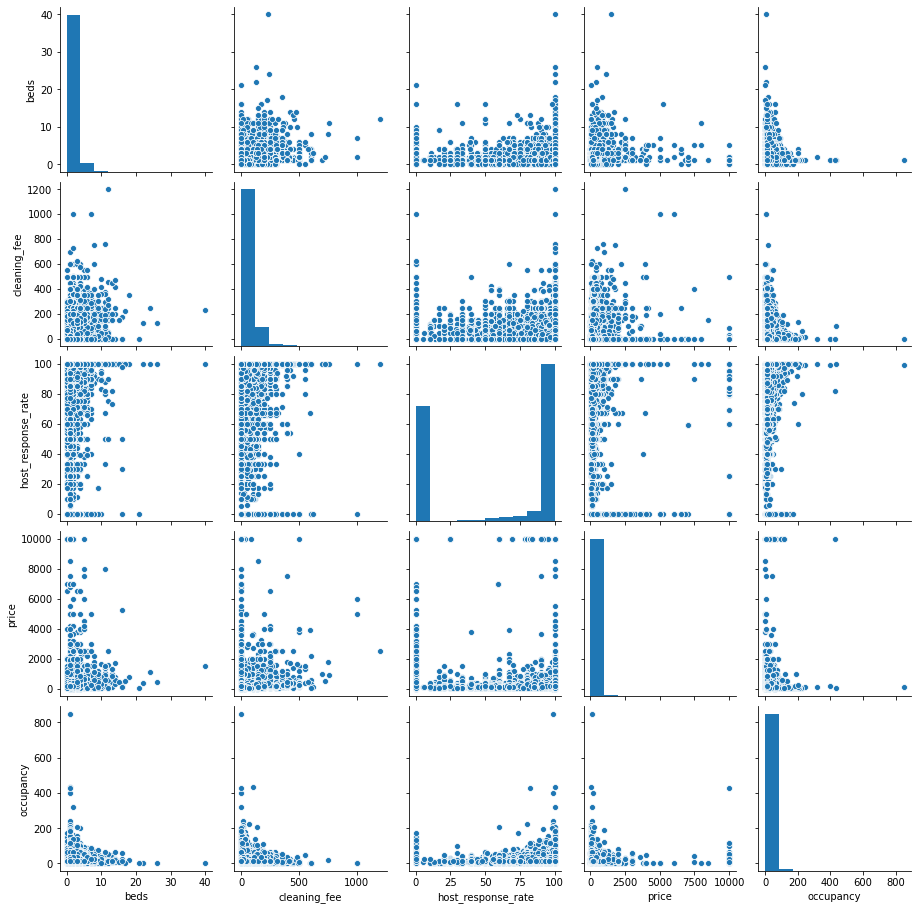

In [ ]:

cols_visualize = ['beds', 'cleaning_fee', 'host_response_rate', 'price', 'occupancy']
sns.pairplot(cleaned_listing_detail[cols_visualize])

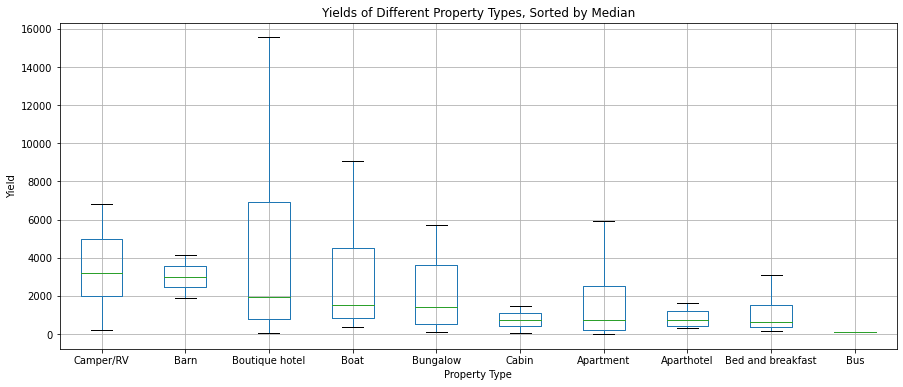

In [ ]:


groupbytype = cleaned_listing_detail.groupby('property_type')
temp = pd.DataFrame({col:vals['yield'] for col,vals in groupbytype})

meds = temp.median()[:10] # only show top 10
meds.sort_values(ascending=False, inplace=True)
temp = temp[meds.index]
plt0 = temp.boxplot(figsize = [15, 6],showfliers=False)
plt0.set_title('Yields of Different Property Types, Sorted by Median')
plt0.set(xlabel="Property Type", ylabel="Yield")
plt.show()


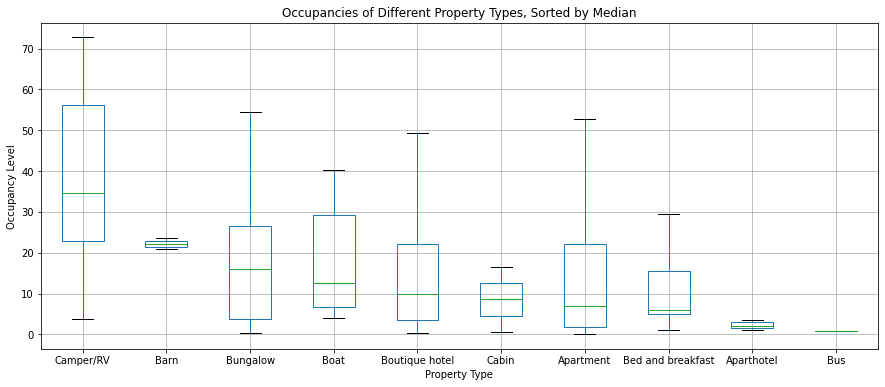

In [ ]:
temp1 = pd.DataFrame({col:vals['occupancy'] for col,vals in groupbytype})
meds1 = temp1.median()[:10] # only show top 10
meds1.sort_values(ascending=False, inplace=True)
temp1 = temp1[meds1.index]
plt1 = temp1.boxplot(figsize = [15, 6],showfliers=False)
plt1.set_title('Occupancies of Different Property Types, Sorted by Median')
plt1.set(xlabel="Property Type", ylabel="Occupancy Level")
plt.show()


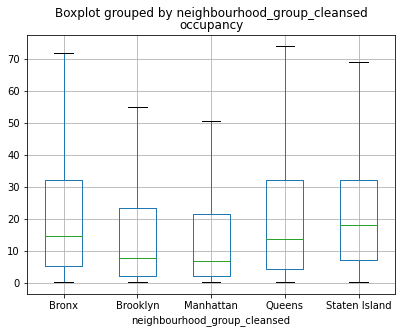

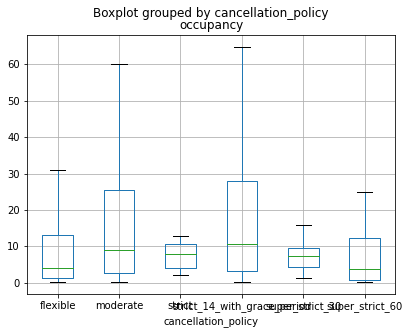

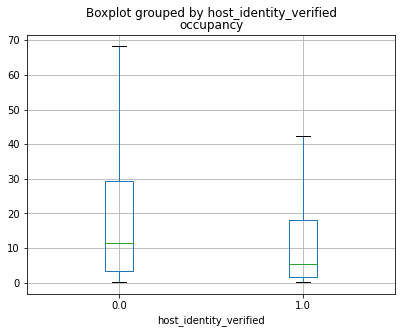

In [ ]:
cleaned_listing_detail.boxplot(column = ['occupancy'],by='neighbourhood_group_cleansed',figsize = [6.4, 4.8],showfliers=False)
cleaned_listing_detail.boxplot(column = ['occupancy'],by='cancellation_policy',figsize = [6.4, 4.8],showfliers=False)
cleaned_listing_detail.boxplot(column = ['occupancy'],by='host_identity_verified',figsize = [6.4, 4.8],showfliers=False)

## Modeling - Text Analysis 

In [ ]:
# drop if needed 
text_vars = ["summary", "occupancy"] 
# df for text analysis purpose 
text_df = listing_detail[text_vars]
text_df.head(5)

,summary,occupancy
0,NaN,0.128
1,"Beautiful, spacious skylit studio in the heart...",4.864
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,60.288
3,My large 1 bedroom apartment has a true New Yo...,7.552
4,NaN,7.168


In [ ]:
# print(text_df['summary'].isnull().sum())
# print(text_df['occupancy'].isnull().sum())
text_df = text_df.dropna();

Text(0.5, 1.0, 'Density Distribution')

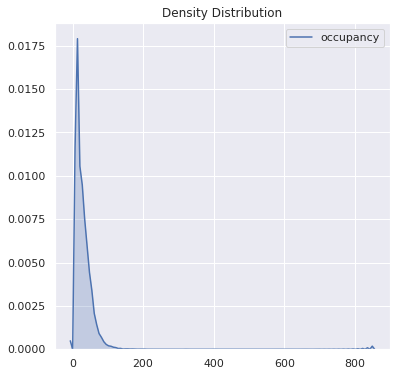

In [ ]:
# Density distribution
sns.set(rc={'figure.figsize':(6,6)})
sns.kdeplot(text_df["occupancy"], shade = True).set_title('Density Distribution')

We can see our "occupancy" is uneven distributed. If we use the average to measure whether the list is highly occupied or not, may cause bias in data. Use the median to be the divided line between high occupancy and low occupancy is much better.

We divided occupancy into two categories， high occupancy and low occupancy. High occupancy is defined as the occupancy which is larger than or equal to the median. Low occupancy is defined as the occupancy which is smaller than the median.

In [ ]:
# Get the median of occupancy
median_occupancy = text_df.median(axis = 0, skipna = True, numeric_only = True)
print("The median occupancy is " + str(median_occupancy['occupancy']))
print("The average occupancy is " + str(text_df['occupancy'].mean()))


text_df['occupancy_above_median'] = text_df['occupancy'].apply(lambda x: 1 if x > median_occupancy['occupancy'] else 0)

The median occupancy is 8.192
The average occupancy is 16.567428482748536


In [ ]:
text_df.head()

,summary,occupancy,occupancy_above_median
1,"Beautiful, spacious skylit studio in the heart...",4.864,0
2,Urban retreat: enjoy 500 s.f. floor in 1899 br...,60.288,1
3,My large 1 bedroom apartment has a true New Yo...,7.552,0
6,Please don’t expect the luxury here just a bas...,45.568,1
7,"Our best guests are seeking a safe, clean, spa...",11.776,1


We tend to use two kind of model to analyze whether the descirption have some relationship with high or low occupancy. The first model is Logistic Regression and second model is Navie Basyes. 

We use four method to deal with the words for each model, binary, counts, tfidf and n-gram.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [ ]:
# split the train and test data
text_X = text_df['summary']
text_Y = text_df['occupancy_above_median']
text_X_train, text_X_test, text_Y_train, text_Y_test = train_test_split(text_X, text_Y, test_size = 0.2, random_state = 42) 

In [ ]:
# Get ROC of every models
def get_model_roc(models, Xs_test, names, Y_test):
    plt.rcParams['figure.dpi'] = 100
    for i in range(len(models)):
        model = models[i]
        X_test = Xs_test[i]
        name = names[i]
        probs = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, probs)
        plt.plot(fpr, tpr, label = name)
        plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        print ("AUC for {0} = {1:.3f}".format(name, metrics.roc_auc_score(Y_test, probs)))
    plt.legend()
    plt.show()

In [ ]:
# first we use binary representation
# Fit a counter
binary_vectorizer = CountVectorizer(binary = True)
binary_vectorizer.fit(text_X_train)

# Transform to counter
text_X_train_binary = binary_vectorizer.transform(text_X_train)
text_X_test_binary = binary_vectorizer.transform(text_X_test)

# Model 
model_binary = LogisticRegression(solver = 'liblinear')
model_binary.fit(text_X_train_binary, text_Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# second we use counts instead of binary
# Fit a counter
count_vectorizer = CountVectorizer()
count_vectorizer.fit(text_X_train)

# Transform to counter
text_X_train_counts = count_vectorizer.transform(text_X_train)
text_X_test_counts = count_vectorizer.transform(text_X_test)

# Model 
model_count = LogisticRegression(solver = 'liblinear')
model_count.fit(text_X_train_counts, text_Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# third we use tf-idf
# Fit a counter
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(text_X_train)

# Transform to counter
text_X_train_tfidf = tfidf_vectorizer.transform(text_X_train)
text_X_test_tfidf = tfidf_vectorizer.transform(text_X_test)

# Model
model_tfidf = LogisticRegression(solver = 'liblinear')
model_tfidf.fit(text_X_train_tfidf, text_Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# fourth we use n-gram
# Fit a counter
ngram_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
ngram_vectorizer.fit(text_X_train)

# Transform to counter
text_X_train_ngram = ngram_vectorizer.transform(text_X_train)
text_X_test_ngram = ngram_vectorizer.transform(text_X_test)

# Model
model_ngram = LogisticRegression(solver = 'liblinear')
model_ngram.fit(text_X_train_ngram, text_Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# take a look at accuarcy of train set
print("The binary LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_binary.predict(text_X_train_binary), text_Y_train)))
print("The counts LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_count.predict(text_X_train_counts), text_Y_train)))
print("The tfifd LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_tfidf.predict(text_X_train_tfidf), text_Y_train)))
print("The n-gram LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_ngram.predict(text_X_train_ngram), text_Y_train)))

The binary LogisticRegression's accuracy is 0.8205567590287433
The counts LogisticRegression's accuracy is 0.820427430566782
The tfifd LogisticRegression's accuracy is 0.7468718678263119
The n-gram LogisticRegression's accuracy is 0.8504962979727764


AUC for Train binary LR = 0.902
AUC for Train counts LR = 0.902
AUC for Train tfidf LR = 0.824
AUC for Train ngram LR = 0.925


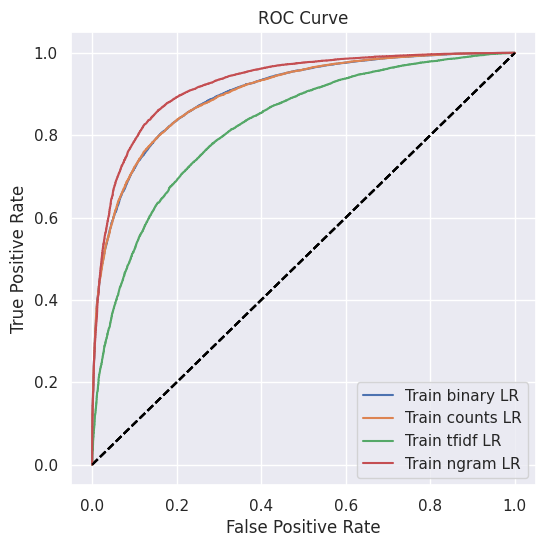

In [ ]:
# take a look at AUC of train set
get_model_roc([model_binary, model_count, model_tfidf, model_ngram], [text_X_train_binary, text_X_train_counts, text_X_train_tfidf, text_X_train_ngram],
              ["Train binary LR", "Train counts LR", "Train tfidf LR", "Train ngram LR"], text_Y_train)

In [ ]:
print("The binary LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_binary.predict(text_X_test_binary), text_Y_test)))
print("The counts LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_count.predict(text_X_test_counts), text_Y_test)))
print("The tfifd LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_tfidf.predict(text_X_test_tfidf), text_Y_test)))
print("The n-gram LogisticRegression's accuracy is " + str(metrics.accuracy_score(model_ngram.predict(text_X_test_ngram), text_Y_test)))

The binary LogisticRegression's accuracy is 0.6796844691581534
The counts LogisticRegression's accuracy is 0.6790378895642053
The tfifd LogisticRegression's accuracy is 0.6860209491788439
The n-gram LogisticRegression's accuracy is 0.6931333247122721


AUC for binary LR = 0.739
AUC for counts LR = 0.738
AUC for tfidf LR = 0.748
AUC for ngram LR = 0.763


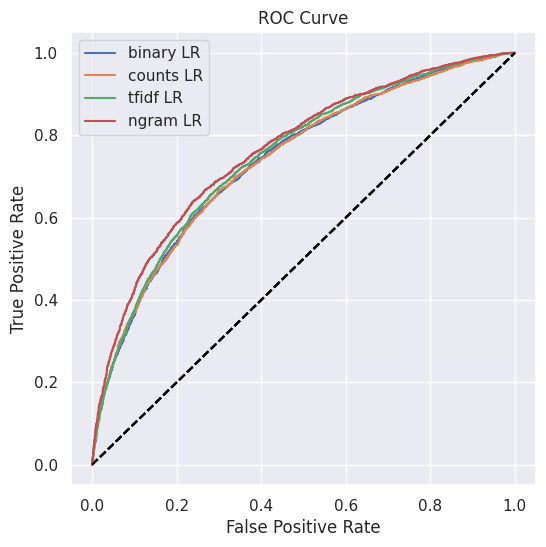

In [ ]:
get_model_roc([model_binary, model_count, model_tfidf, model_ngram], [text_X_test_binary, text_X_test_counts, text_X_test_tfidf, text_X_test_ngram],
              ["binary LR", "counts LR", "tfidf LR", "ngram LR"], text_Y_test)

From the image above, we can see that ngram is a little better than others.

Let use Naive Bayes to fit the problem again.

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
# NB model to fit four kinds of dealing words methods
model_nb_binary = BernoulliNB()
model_nb_binary.fit(text_X_train_binary, text_Y_train)

model_nb_count = BernoulliNB()
model_nb_count.fit(text_X_train_counts, text_Y_train)

model_nb_tfidf = BernoulliNB()
model_nb_tfidf.fit(text_X_train_tfidf, text_Y_train)

model_nb_ngram = BernoulliNB()
model_nb_ngram.fit(text_X_train_ngram, text_Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
# take a look at accuarcy of train set
print("The binary NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_binary.predict(text_X_train_binary), text_Y_train)))
print("The counts NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_count.predict(text_X_train_counts), text_Y_train)))
print("The tfifd NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_tfidf.predict(text_X_train_tfidf), text_Y_train)))
print("The n-gram NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_ngram.predict(text_X_train_ngram), text_Y_train)))

The binary NaiveBayes's accuracy is 0.7158977011865887
The counts NaiveBayes's accuracy is 0.7158977011865887
The tfifd NaiveBayes's accuracy is 0.7158977011865887
The n-gram NaiveBayes's accuracy is 0.8841540301981958


AUC for Train binary NB = 0.794
AUC for Train counts NB = 0.794
AUC for Train tfidf NB = 0.794
AUC for Train ngram NB = 0.968


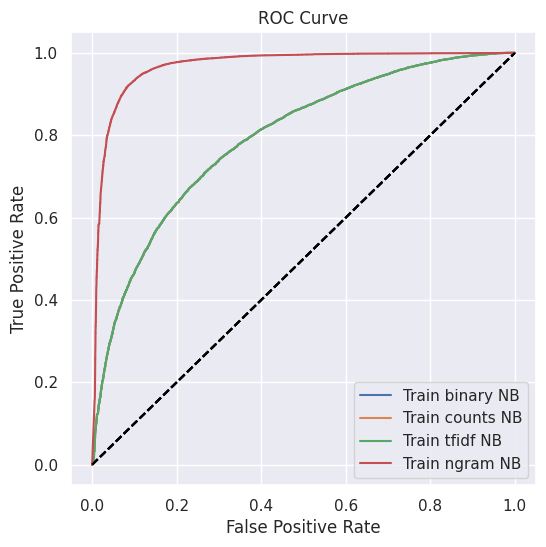

In [ ]:
get_model_roc([model_nb_binary, model_nb_count, model_nb_tfidf, model_nb_ngram], [text_X_train_binary, text_X_train_counts, text_X_train_tfidf, text_X_train_ngram],
              ["Train binary NB", "Train counts NB", "Train tfidf NB", "Train ngram NB"], text_Y_train)

In [ ]:
print("The binary NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_binary.predict(text_X_test_binary), text_Y_test)))
print("The counts NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_count.predict(text_X_test_counts), text_Y_test)))
print("The tfifd NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_tfidf.predict(text_X_test_tfidf), text_Y_test)))
print("The n-gram NaiveBayes's accuracy is " + str(metrics.accuracy_score(model_nb_ngram.predict(text_X_test_ngram), text_Y_test)))

The binary NaiveBayes's accuracy is 0.6692098797361955
The counts NaiveBayes's accuracy is 0.6692098797361955
The tfifd NaiveBayes's accuracy is 0.6692098797361955
The n-gram NaiveBayes's accuracy is 0.6857623173412647


AUC for binary NB = 0.728
AUC for counts NB = 0.728
AUC for tfidf NB = 0.728
AUC for ngram NB = 0.762


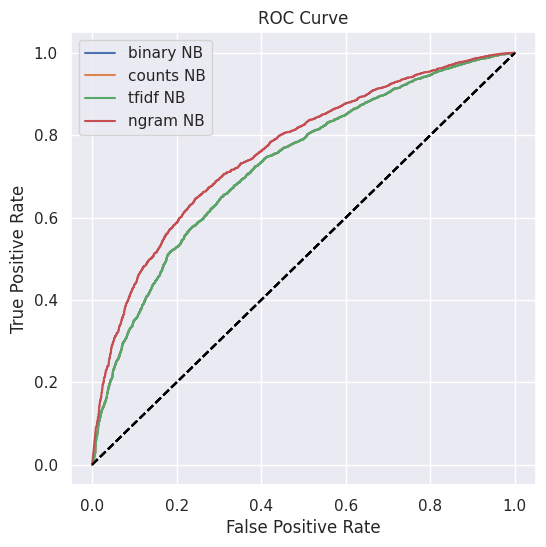

In [ ]:
get_model_roc([model_nb_binary, model_nb_count, model_nb_tfidf, model_nb_ngram], [text_X_test_binary, text_X_test_counts, text_X_test_tfidf, text_X_test_ngram],
              ["binary NB", "counts NB", "tfidf NB", "ngram NB"], text_Y_test)

Now we can see that n-gram perform a littel better than others. We can also chekc what is the top 100 key words.

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn = 100):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [ ]:
feature_names = ngram_vectorizer.get_feature_names()
ngram_v = ngram_vectorizer.transform(text_X)
sorted_items = sort_coo(ngram_v.tocoo())
keywords = extract_topn_from_vector(feature_names, sorted_items, 100)
keywords_filtered = []
discard = ['minimum nights', 'apartment really', 'available booking', 'apartment located']
for k in keywords:
  print(k, keywords[k])
  if len(k.split()) > 1 and k not in discard: # we want to discard single word since keywords like "bed", "listing" are very comman 
    keywords_filtered.append(k)

超市 1.0
法拉盛奢华房 1.0
大单房 1.0
yolo 1.0
welcome 1.0
roommates 1.0
room 1.0
quite 1.0
quiet 1.0
new 1.0
later 1.0
hi 1.0
guest 1.0
fc 1.0
duplex 1.0
downtown 1.0
cosy 1.0
comfortable 1.0
chill 1.0
bogota 1.0
bedroom 1.0
bed 1.0
apple 1.0
apa 1.0
aas 1.0
aa 1.0
refreshing 0.934
bunkbed 0.931
hole 0.931
great apartment 0.912
close stores 0.889
shared studio 0.887
luxury house 0.883
great studio 0.881
excellent room 0.88
amazing apartment 0.879
beautiful home 0.875
love apartment 0.872
cozy space 0.868
room bathroom 0.864
new new 0.86
perfect bedroom 0.857
cozy spacious 0.856
comfortable room 0.849
backyard available 0.848
artist room 0.845
awesome place 0.842
bright rooms 0.84
nearby trains 0.837
beautiful environment 0.837
listing room 0.835
great night 0.834
twin private 0.831
book market 0.826
modern studio 0.823
bright cozy 0.822
simple modern 0.819
family brownstone 0.816
location location 0.816
includes internet 0.814
nice clean 0.809
nice environment 0.809
nice view 0.805
apartment loca

Since we have identified some important key words in summary, we went over our "summary" columns, and convert the text to 1 if some important key words are present, otherwise 0. To avoid complexity issue, we do not choose to include these the presence of each key word as dummy.

In [ ]:

def has_keywords(text):
  for w in keywords_filtered:
    if w in text:
      return 1
  return 0

df_dummified['summary'] = df_dummified['summary'].apply(lambda x: has_keywords(x))

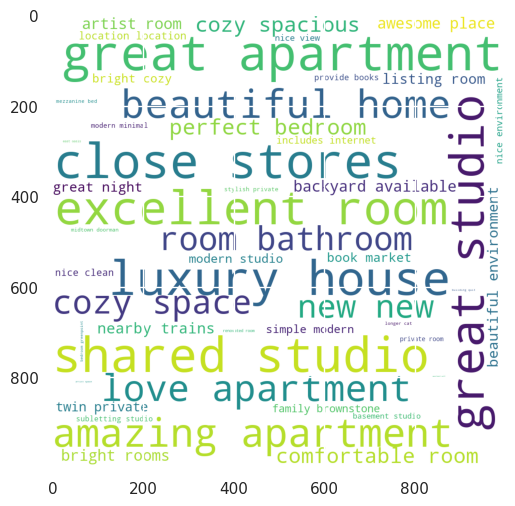

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = {w:len(keywords_filtered) - i for i, w in enumerate(keywords_filtered)}
wcplt = WordCloud(background_color="white",width=1000, height=1000, relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(wc)
plt.imshow(wcplt)

## Modeling



In [ ]:
# imports 
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

### Regression Model on Predicting Occupancy

In [ ]:
cols = list(df_dummified.columns) # all columns 

targets = ["occupancy", "yield", "relative_ocupancy"] # non-features cols
features = [x for x in cols if x not in targets] # all features

# categorize our features 
features_des = cols[:6]
features_host = cols[6:12]
features_proptype = cols[27:37]
features_roombed = cols[37:46]
features_policy = cols[46:52]
features_neigb = cols[52:63]
features_ammen = cols[63:]
features_basic = [x for x in cols[12:26] if x not in targets]

In [ ]:
# train test split
X = df_dummified[features]
Y = df_dummified.occupancy
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [ ]:
model_list=['Linear','Ridge','KNN','RandomForest','GradientBoosting'] #'Lasso',
scores = pd.DataFrame({'Model':model_list})

def training(X, Y):
    results=[]    
    model1 = LinearRegression()
    model2 = Ridge()
    model3 = KNeighborsRegressor(n_neighbors = 15)
    model4 = RandomForestRegressor(max_depth = 35)
    model5 = GradientBoostingRegressor()
    models= [model1,model2, model3, model4,model5] # 
    
    for m in models:
        r2 = cross_val_score(m, X, Y, cv = 10, scoring="r2").mean()
        results.append(r2)
    
    return results

#### Basic Features

In [ ]:
flist = features_basic
results = training(X[flist], Y)
scores['basic']=results
scores

,Model,basic
0,Linear,-0.001787
1,Ridge,-0.001788
2,KNN,-0.068468
3,RandomForest,-0.031600
4,GradientBoosting,0.067623


#### Add features: Property Types

In [ ]:
flist += features_proptype
results = training(X[flist], Y)
scores['Added Property Types']=results
scores

,Model,basic,Added Property Types
0,Linear,-0.001787,0.016749
1,Ridge,-0.001788,0.016745
2,KNN,-0.068468,-0.065180
3,RandomForest,-0.031600,0.014976
4,GradientBoosting,0.067623,0.084341


#### Add features: Host Information

In [ ]:
flist += features_host
results = training(X[flist], Y)
scores['Added Host Info']=results
scores

,Model,basic,Added Property Types,Added Host Info
0,Linear,-0.001787,0.016749,0.272368
1,Ridge,-0.001788,0.016745,0.272369
2,KNN,-0.068468,-0.065180,0.275305
3,RandomForest,-0.031600,0.014976,0.417146
4,GradientBoosting,0.067623,0.084341,0.396122


#### Add features: Room & Bed Types 


In [ ]:
flist += features_roombed
results = training(X[flist], Y)
scores['Added Room&Bed Types']=results
scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types
0,Linear,-0.001787,0.016749,0.272368,0.271984
1,Ridge,-0.001788,0.016745,0.272369,0.271995
2,KNN,-0.068468,-0.065180,0.275305,0.276261
3,RandomForest,-0.031600,0.014976,0.417146,0.419661
4,GradientBoosting,0.067623,0.084341,0.396122,0.397274


#### Add features: Cancellation Policy 

In [ ]:
flist += features_policy
results = training(X[flist], Y)
scores['Added Cancel Policy']=results
scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy
0,Linear,-0.001787,0.016749,0.272368,0.271984,0.274941
1,Ridge,-0.001788,0.016745,0.272369,0.271995,0.275018
2,KNN,-0.068468,-0.065180,0.275305,0.276261,0.275423
3,RandomForest,-0.031600,0.014976,0.417146,0.419661,0.422973
4,GradientBoosting,0.067623,0.084341,0.396122,0.397274,0.396726


#### Add features: Neighborhood

In [ ]:
flist += features_neigb
results = training(X[flist], Y)
scores['Added Neighborhood']=results
scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy,Added Neighborhood
0,Linear,-0.001787,0.016749,0.272368,0.271984,0.274941,0.277263
1,Ridge,-0.001788,0.016745,0.272369,0.271995,0.275018,0.277349
2,KNN,-0.068468,-0.065180,0.275305,0.276261,0.275423,0.275988
3,RandomForest,-0.031600,0.014976,0.417146,0.419661,0.422973,0.433747
4,GradientBoosting,0.067623,0.084341,0.396122,0.397274,0.396726,0.397224


#### Add features: Amenities

In [ ]:
flist += features_ammen
results = training(X[flist], Y)
scores['Added Amenities']=results
scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy,Added Neighborhood,Added Amenities
0,Linear,-0.001787,0.016749,0.272368,0.271984,0.274941,0.277263,0.300916
1,Ridge,-0.001788,0.016745,0.272369,0.271995,0.275018,0.277349,0.301001
2,KNN,-0.068468,-0.065180,0.275305,0.276261,0.275423,0.275988,0.276809
3,RandomForest,-0.031600,0.014976,0.417146,0.419661,0.422973,0.433747,0.442516
4,GradientBoosting,0.067623,0.084341,0.396122,0.397274,0.396726,0.397224,0.409316


#### Add features: Listing Description

In [ ]:
flist += features_des
results = training(X[flist], Y)
scores['Added Description'] = results
scores

In [ ]:
scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy,Added Neighborhood,Added Amenities,Added Description
0,Linear,-0.001787,0.016749,0.272368,0.271984,0.274941,0.277263,0.300916,0.302755
1,Ridge,-0.001788,0.016745,0.272369,0.271995,0.275018,0.277349,0.301001,0.302824
2,KNN,-0.068468,-0.065180,0.275305,0.276261,0.275423,0.275988,0.276809,0.276763
3,RandomForest,-0.031600,0.014976,0.417146,0.419661,0.422973,0.433747,0.442516,0.440957
4,GradientBoosting,0.067623,0.084341,0.396122,0.397274,0.396726,0.397224,0.409316,0.408426


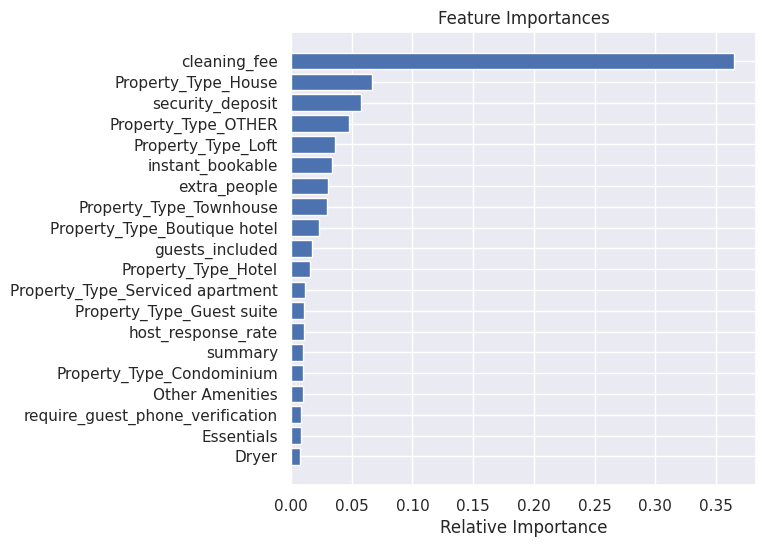

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X[features], Y)
importances = rfr.feature_importances_
indices = np.argsort(importances)[-20:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [flist[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Classifier Model on Predicting Relative Occupancy

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
clfs =['KNN','RandomForest','GradientBoosting', 'LogisticRegression']
clfs_scores = pd.DataFrame({'Model': clfs})
Y = df_dummified.relative_ocupancy
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

def clf_train(X, Y):
    results=[]
    model1 = KNeighborsClassifier(15)
    model2 = RandomForestClassifier(max_depth = 40)
    model3 = GradientBoostingClassifier(n_estimators = 115)
    model4 = LogisticRegression(random_state=0)
    models= [model1,model2,model3,model4]
    
    for m in models:
        accu = cross_val_score(m, X, Y, cv=10, scoring="accuracy").mean()
        results.append(accu)
    return results

#### Basic Features

In [ ]:
features_basic = [x for x in cols[12:26] if x not in targets]
flist = features_basic
results = clf_train(X_train[flist], Y_train) # use train data X_train, X_test, Y_train, Y_test 
clfs_scores['basic']=results
clfs_scores

,Model,basic
0,KNN,0.608594
1,RandomForest,0.639021
2,GradientBoosting,0.651372
3,LogisticRegression,0.614285


#### Add features: Property Types

In [ ]:
flist += features_proptype
results = clf_train(X_train[flist], Y_train)
clfs_scores['Added Property Types']=results
clfs_scores

,Model,basic,Added Property Types
0,KNN,0.608594,0.609564
1,RandomForest,0.639021,0.649239
2,GradientBoosting,0.651372,0.657192
3,LogisticRegression,0.614285,0.618908


#### Add features: Host Information

In [ ]:
flist += features_host
results = clf_train(X_train[flist], Y_train)
clfs_scores['Added Host Info']=results
clfs_scores

,Model,basic,Added Property Types,Added Host Info
0,KNN,0.608594,0.609564,0.788857
1,RandomForest,0.639021,0.649239,0.818767
2,GradientBoosting,0.651372,0.657192,0.814595
3,LogisticRegression,0.614285,0.618908,0.771947


#### Add features: Room & Bed Types 


In [ ]:
flist += features_roombed
results = clf_train(X_train[flist], Y_train)
clfs_scores['Added Room&Bed Types']=results
clfs_scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types
0,KNN,0.608594,0.609564,0.788857,0.788663
1,RandomForest,0.639021,0.649239,0.818767,0.818508
2,GradientBoosting,0.651372,0.657192,0.814595,0.815695
3,LogisticRegression,0.614285,0.618908,0.771947,0.772464


#### Add features: Cancellation Policy 

In [ ]:
flist += features_policy
results = clf_train(X_train[flist], Y_train)
clfs_scores['Added Cancel Policy']=results
clfs_scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy
0,KNN,0.608594,0.609564,0.788857,0.788663,0.788405
1,RandomForest,0.639021,0.649239,0.818767,0.818508,0.819672
2,GradientBoosting,0.651372,0.657192,0.814595,0.815695,0.815468
3,LogisticRegression,0.614285,0.618908,0.771947,0.772464,0.775342


#### Add features: Neighborhood

In [ ]:
flist += features_neigb
results = clf_train(X_train[flist], Y_train)
clfs_scores['Added Neighborhood']=results
clfs_scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy,Added Neighborhood
0,KNN,0.608594,0.609564,0.788857,0.788663,0.788405,0.788696
1,RandomForest,0.639021,0.649239,0.818767,0.818508,0.819672,0.820448
2,GradientBoosting,0.651372,0.657192,0.814595,0.815695,0.815468,0.816083
3,LogisticRegression,0.614285,0.618908,0.771947,0.772464,0.775342,0.773984


#### Add features: Amenities

In [ ]:
flist += features_ammen
results = clf_train(X_train[flist], Y_train)
clfs_scores['Added Amenities']=results
clfs_scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy,Added Neighborhood,Added Amenities
0,KNN,0.608594,0.609564,0.788857,0.788663,0.788405,0.788696,0.788502
1,RandomForest,0.639021,0.649239,0.818767,0.818508,0.819672,0.820448,0.822712
2,GradientBoosting,0.651372,0.657192,0.814595,0.815695,0.815468,0.816083,0.818282
3,LogisticRegression,0.614285,0.618908,0.771947,0.772464,0.775342,0.773984,0.770556


#### Add features: Listing Description

In [ ]:
flist += features_des
results = clf_train(X_train[flist], Y_train)
clfs_scores['Added Description'] = results
clfs_scores

,Model,basic,Added Property Types,Added Host Info,Added Room&Bed Types,Added Cancel Policy,Added Neighborhood,Added Amenities,Added Description
0,KNN,0.608594,0.609564,0.788857,0.788663,0.788405,0.788696,0.788502,0.788469
1,RandomForest,0.639021,0.649239,0.818767,0.818508,0.819672,0.820448,0.822712,0.823261
2,GradientBoosting,0.651372,0.657192,0.814595,0.815695,0.815468,0.816083,0.818282,0.818443
3,LogisticRegression,0.614285,0.618908,0.771947,0.772464,0.775342,0.773984,0.770556,0.773790


### Parameter Tuning

#### KNN: Find optimal n_neighbors

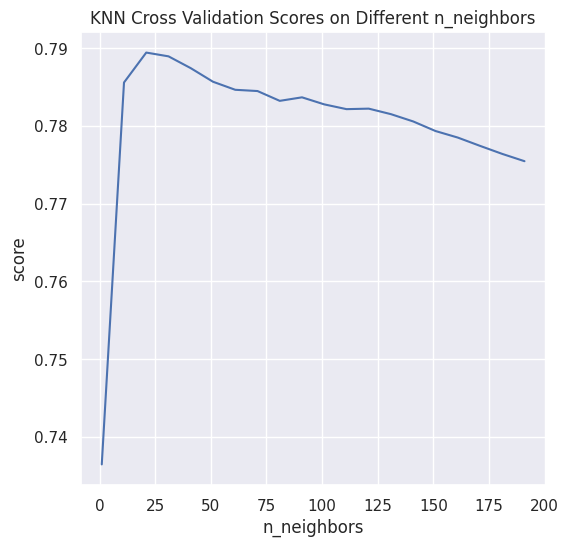

KNN:
best accuracy:0.7894402269732109
best n_neighbors:21


In [ ]:
kvals = np.arange(1,200,10) # n_neighbors values to try 
accurs_KNN = []

for k in kvals:
    knc = KNeighborsClassifier(n_neighbors = k)
    acc = cross_val_score (knc, X_train[flist], Y_train, cv=15, scoring="accuracy").mean()
    accurs_KNN.append(acc)
    
plt.plot(kvals, accurs_KNN, label="knn")
plt.title('KNN Cross Validation Scores on Different n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.show()

knn=pd.DataFrame(kvals,columns=['k'])
knn['accuracy']=accurs_KNN
best_accuracy=knn['accuracy'].max()
best_k=knn.sort_values(by=['accuracy'],ascending=False).k.values[0]

print("KNN:")
print("best accuracy:"+str(best_accuracy))
print("best n_neighbors:"+str(best_k))

#### Random Forest Classifier: Find optimal n_estimators


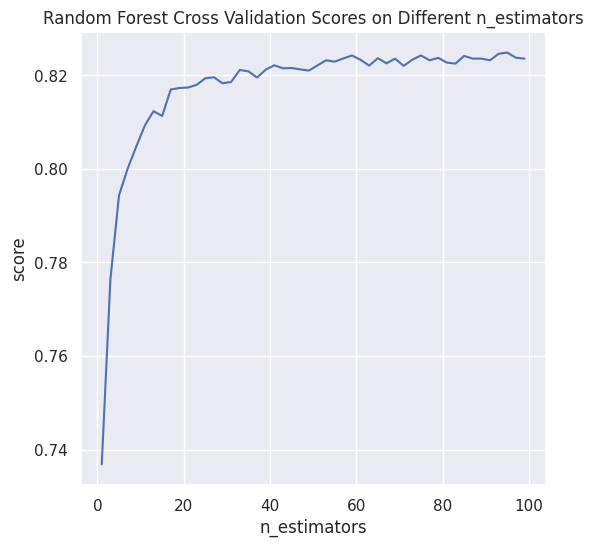

RandomForest:
best accuracy:0.8248454340623926
best n_estimators:95


In [ ]:
n_estimators = np.arange(1,100,2) # n_estimators values to try 
accurs_RF = []

for n in n_estimators:
    rfr = RandomForestClassifier(n_estimators = n) # num of trees in the forest 
    acc = cross_val_score(rfr, X_train[flist], Y_train, cv=10, scoring="accuracy").mean()
    accurs_RF.append(acc)

plt.plot(n_estimators,accurs_RF,label="RandomForestClassifier")
plt.title('Random Forest Cross Validation Scores on Different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

RandForest=pd.DataFrame(n_estimators,columns=['n_estimators'])
RandForest['accuracy']=accurs_RF
best_accuracy=RandForest['accuracy'].max()
best_n=RandForest.sort_values(by=['accuracy'],ascending=False).n_estimators.values[0]

print("RandomForest:")
print("best accuracy:"+str(best_accuracy))
print("best n_estimators:"+str(best_n))

#### Gradient Boosting Classifier

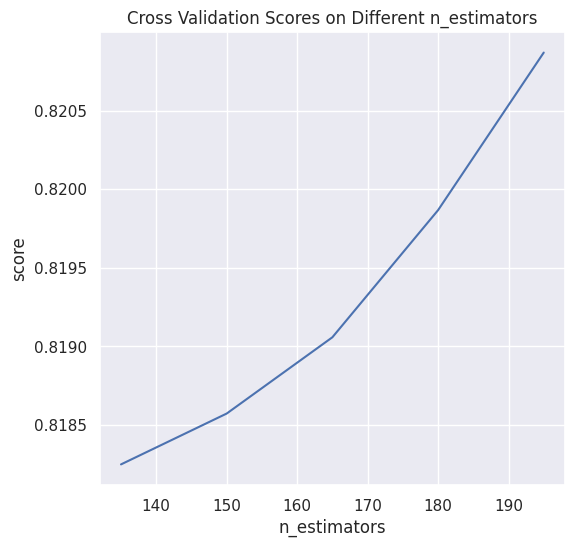

GradientBoostingClassifier:
best accuracy:0.8208685998481805
best_n_estimator :195


In [ ]:
gb_n_estimators = np.arange(135,200,15)
accurs_GB=[]

for n in gb_n_estimators:
    gbc =  GradientBoostingClassifier(n_estimators = n)
    acc=cross_val_score(gbc, X_train[flist], Y_train, cv=15, scoring="accuracy").mean()
    accurs_GB.append(acc)
    
plt.plot(gb_n_estimators,accurs_GB,label="GradientBoostingClassifier")
plt.title('Cross Validation Scores on Different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

GB_estimators=pd.DataFrame(gb_n_estimators, columns=['n'])
GB_estimators['accuracy']=accurs_GB
best_accuracy=GB_estimators['accuracy'].max()
best_n_estimator=GB_estimators.sort_values(by=['accuracy'],ascending=False).n.values[0]

print("GradientBoostingClassifier:")
print("best accuracy:"+str(best_accuracy))
print("best_n_estimator :"+str(best_n_estimator))

### Model Performance 

#### ROC

In [ ]:
# ROC curve 
# This model is taken from foster_2020/Module6
def get_model_roc(models, X_test, names, Y_test):
    plt.rcParams['figure.dpi'] = 100
    for i in range(len(models)):
        model = models[i]
        name = names[i]
        probs = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, probs)
        plt.plot(fpr, tpr, label=name)
        plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        print ("AUC for {0} = {1:.3f}".format(name, metrics.roc_auc_score(Y_test, probs)))
    plt.legend()
    plt.show()


AUC for KNN = 0.857
AUC for RandomForest = 0.906
AUC for GradiantBoosting = 0.906


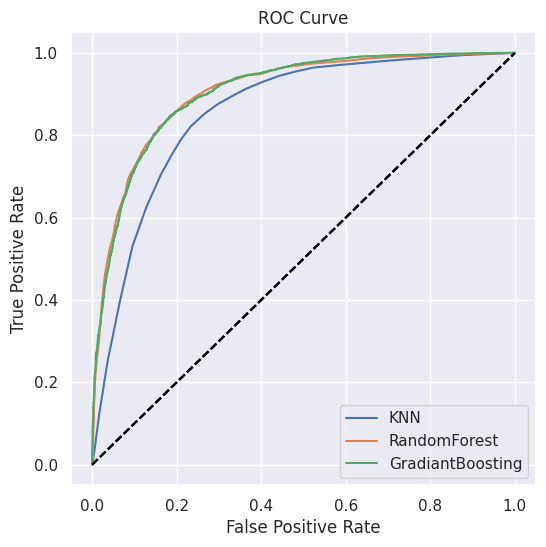

In [ ]:
# plot ROC curves for classifiers with optimal parameter values, on test data 
model_knc = KNeighborsClassifier(n_neighbors = best_k)
model_knc.fit(X_train, Y_train)
model_rfr = RandomForestClassifier(n_estimators = best_n)
model_rfr.fit(X_train, Y_train)
model_gbc = GradientBoostingClassifier(n_estimators = best_n_estimator)
model_gbc.fit(X_train, Y_train)
get_model_roc([model_knc, model_rfr, model_gbc], X_test, ['KNN', 'RandomForest', 'GradiantBoosting'], Y_test)

Show features importance

Code source cited: https://medium.com/@garg.mohit851/random-forest-visualization-3f76cdf6456f

#### Feature Importance

In [ ]:

# #modelname.feature_importance_
# y = model_rfr.feature_importances_
# #plot
# fig, ax = plt.subplots() 
# width = 0.4 # the width of the bars 
# ind = np.arange(len(y)) # the x locations for the groups
# ax.barh(ind, y, width, color="green")
# ax.set_yticks(ind+width/10)
# ax.set_yticklabels(flist, minor=False)
# plt.title('Feature importance in RandomForest Classifier')
# plt.xlabel('Relative importance')
# plt.ylabel('feature') 
# plt.figure(figsize=(5,20))
# fig.set_size_inches(6.5, 4.5, forward=True)
# plt.show()



importances = model_rfr.feature_importances_
indices = np.argsort(importances)[-20:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [flist[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

NameError: ignored

#### Confusion matrix

In [ ]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

tick_labels = ["Higher Than Median", "Lower Than Median"]
def plot_matrix(mat, title, remove_diagonal=True):
    error_mat = mat.copy()
    if remove_diagonal:
        diag_ixs = np.arange(mat.shape[0])
        error_mat[diag_ixs, diag_ixs] = 0
    sns.heatmap(error_mat, annot=True, fmt='d', yticklabels=tick_labels, xticklabels=tick_labels)
    plt.ylabel('Predictions')
    plt.xlabel('True labels')
    plt.title(title)


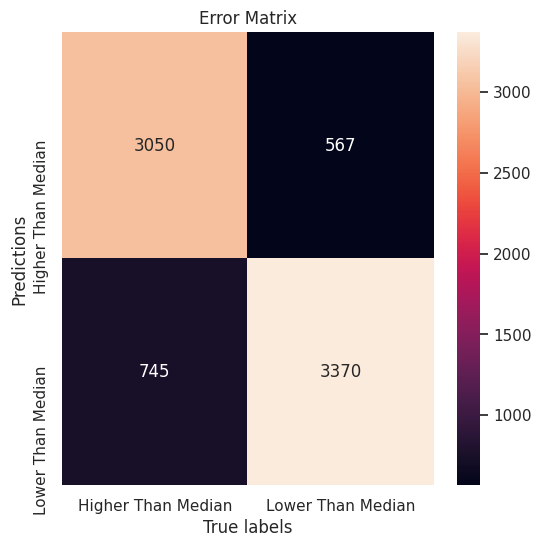

In [ ]:
best_model = model_rfr
Y_predicted=best_model.predict(X_test)

conf_mat = confusion_matrix(Y_predicted, Y_test)
plot_matrix(conf_mat, 'Error Matrix', remove_diagonal=False)